# Test pour prédire le type de cancer (microarray data)
Flückiger Nathan, Vincent Guidoux et Joel Kaufmann

## Préparation des données

### Importation des bibliothèques

In [1]:
import os
import time
import numpy as np
import pylab as plt
import pandas as pd

from Bio import Geo

from sklearn import svm
from sklearn import tree
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression

%matplotlib inline

### Importation des données

In [2]:
def load_geo(myfile):
    handle = open(myfile)
    records = Geo.parse(handle)
    return records

In [3]:
records = load_geo('GDS4296.soft')

# description of each condition (cell type)
id_cond = {}  

cancer_set = set()

# loop over records
for r in records:    
    
    rea = r.entity_attributes
    
    #if rea.has_key('subset_sample_id'): 
    if 'subset_sample_id' in rea:
        
        # find conditions associated with each cell type
        if rea['subset_type']=='disease state':
            sample_list = rea['subset_sample_id'].split(',')
            desc = rea['subset_description']
            cancer_set.add(desc)
            for sample in sample_list:
                id_cond[sample] = desc

    #if rea.has_key('dataset_table_begin'): # it's the gene expression data
    if 'dataset_table_begin' in rea:
        data = r.table_rows

# converts data to an array (more practical to handle)
data = np.array(data) 

**Combien y'a-t-il de cellules cancereuses en tout ?**

In [4]:
len(id_cond)

174

**Comment sont-elles réparties ?**

In [5]:
disease_repartition = {}

for disease in id_cond.values():
    if disease in disease_repartition.keys():
        disease_repartition[disease] = disease_repartition[disease] + 1
    else:
        disease_repartition[disease] = 1
        
disease_repartition

{'Adenocarcinoma': 60,
 'Acute lymphoblastic leukemia': 6,
 'Astrocytoma': 3,
 'Chronic myelogenous leukemia': 3,
 'Carcinoma': 12,
 'Carcinosarcoma': 3,
 'Clear cell carcinoma': 2,
 'Cystoadenocarcinoma': 3,
 'Ductal carcinoma': 3,
 'Glial cell neoplasm': 3,
 'Glioblastoma': 12,
 'Large cell carcinoma': 6,
 'Lymphoma': 3,
 'Malignant amelanotic melanoma': 3,
 'Malignant melanotic melanoma': 11,
 'Melanotic melanoma': 9,
 'Myeloma': 3,
 'Papillary infiltrating ductal carcinoma': 3,
 'Pro myelocytic leukemia': 3,
 'Renal spindle cell carcinoma': 3,
 'Renal cell carcinoma': 9,
 'Small cell bronchioalveolar carcinoma': 3,
 'Squamous cell carcinoma': 2,
 'Hypernephroma': 3,
 'Infiltrating ductal carcinoma': 3}

Aux vues de cette répartition, il nous faut regrouper ces différentes type de cellules, car certains, comme `Squamous cell carcinoma` n'ont que deux cellules, et on ne peut pas se permettre d'en mettre une dans le train-set et une dans le test-set, ce n'est pas assez. Nous allons nous renseigner comment regrouper ces données.

In [6]:
def category_repartition(category):
    """Vous nous aider à voir la répartition des différents échantillons dans les catégories que nous allons définir"""
    total = 0
    for disease in category:
        total += disease_repartition[disease]
        
    return total

**5 catégories ont été choisies :**

Adenocarcinoma :

In [7]:
category_1 = ['Adenocarcinoma']

print("Il y a {} échantillons dans cette catégorie".format(category_repartition(category_1)))

Il y a 60 échantillons dans cette catégorie


Other Carcinoma :

In [8]:
category_2 = [
                'Carcinoma',
                'Carcinosarcoma',
                'Clear cell carcinoma',
                'Cystoadenocarcinoma',
                'Ductal carcinoma',
                'Large cell carcinoma',
                'Papillary infiltrating ductal carcinoma',
                'Renal spindle cell carcinoma',
                'Renal cell carcinoma',
                'Small cell bronchioalveolar carcinoma',
                'Squamous cell carcinoma',
                'Hypernephroma',
                'Infiltrating ductal carcinoma'
            ]

print("Il y a {} échantillons dans cette catégorie".format(category_repartition(category_2)))

Il y a 55 échantillons dans cette catégorie


Leucémie : 

In [9]:
category_3 = [
                'Acute lymphoblastic leukemia',
                'Chronic myelogenous leukemia',
                'Lymphoma',
                'Myeloma',
                'Pro myelocytic leukemia'
            ]

print("Il y a {} échantillons dans cette catégorie".format(category_repartition(category_3)))

Il y a 18 échantillons dans cette catégorie


Mélanome :

In [10]:
category_4 = [
                'Malignant amelanotic melanoma',
                'Malignant melanotic melanoma',
                'Melanotic melanoma'
            ]

print("Il y a {} échantillons dans cette catégorie".format(category_repartition(category_4)))

Il y a 23 échantillons dans cette catégorie


Cerveau :

In [11]:
category_5 = [
                'Astrocytoma',
                'Glial cell neoplasm',
                'Glioblastoma'
            ]

print("Il y a {} échantillons dans cette catégorie".format(category_repartition(category_5)))

Il y a 18 échantillons dans cette catégorie


**Vérifier les écarts-type (variabilité des données) des données des catégories pour confirmer le regroupement des différents type dans une catégorie**

**Ajout de la catégorie**

In [12]:
dataDF_raw = pd.DataFrame(data=data[1:,1:], index=data[1:,0],columns=data[0,1:])
dataDF_raw.head()

,IDENTIFIER,GSM803615,GSM803674,GSM803733,GSM803616,GSM803675,GSM803734,GSM803617,GSM803676,GSM803735,...,GSM803785,GSM803671,GSM803729,GSM803786,GSM803672,GSM803730,GSM803787,GSM803673,GSM803731,GSM803788
1007_s_at,DDR1,7.98588,6.60953,7.28692,6.81414,7.17116,7.22437,8.30001,7.97986,6.8234,...,8.76158,8.87174,9.05203,9.02302,7.90743,7.85594,6.90531,10.799,10.8054,10.9599
1053_at,RFC2,8.91259,8.95833,8.78347,8.68783,8.47835,8.87411,8.48144,8.44854,8.00108,...,9.01109,7.99229,7.89066,7.78652,7.38044,7.94416,8.20352,7.82165,7.71562,7.79544
117_at,HSPA6,5.95818,5.9552,4.75223,4.96283,5.01497,4.78948,4.66964,4.70403,4.69634,...,5.32821,5.22383,5.24615,4.89699,5.5685,4.93727,5.18978,5.01333,4.98273,4.97768
121_at,PAX8,7.25647,7.34984,7.03978,7.23067,7.63878,7.45663,7.60143,7.56602,7.27995,...,7.44675,7.36011,7.30075,7.23286,7.3711,7.40892,7.23629,7.2943,7.2762,7.45836
1255_g_at,GUCA1A,2.70294,2.72227,2.66169,2.79379,2.97056,2.62163,3.09889,2.87228,2.76879,...,2.91059,2.67582,2.74977,2.68969,2.85014,2.794,2.74596,2.74609,2.75365,2.57236


In [13]:
# transposée pour avoir cellule avec les features de ML en lignes
dataDF = pd.DataFrame(data=data[1:,1:], index=data[1:,0],columns=data[0,1:]).transpose() 

dataDF = dataDF.drop('IDENTIFIER') # IDENTIFIER pas utilisé
dataDF = dataDF.iloc[:,:].astype('float64')
dataDF.insert(0, "category", 1,allow_duplicates=True) # création d'une colonne pour les catégorie de regroupement

In [14]:
# set the rigth category for each cell
all_categories = [category_1, category_2, category_3, category_4, category_5] # liste de listes
category_column = []

for index, row in dataDF.iterrows():
    for cat_index in range(len(all_categories)):
        if id_cond[index] in all_categories[cat_index]:
            category_column.append(cat_index + 1) # indices 1-5
            break      

dataDF['category'] = category_column
dataDF.head()

,category,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
GSM803615,3,7.98588,8.91259,5.95818,7.25647,2.70294,7.31083,4.93041,4.50100,2.79874,...,2.45076,3.53323,2.74954,3.15915,3.62218,3.36355,2.67324,2.72860,3.29524,2.80815
GSM803674,3,6.60953,8.95833,5.95520,7.34984,2.72227,6.82958,5.11308,4.64615,2.72531,...,2.45229,3.55865,2.97269,2.99266,3.77177,3.38203,2.88409,2.70408,3.29139,3.09778
GSM803733,3,7.28692,8.78347,4.75223,7.03978,2.66169,6.80481,5.10009,4.29090,2.78749,...,2.58546,3.25001,2.71918,2.97779,3.76105,3.27553,2.64535,2.74768,3.21011,2.99015
GSM803616,3,6.81414,8.68783,4.96283,7.23067,2.79379,6.90361,4.89782,4.54651,7.99732,...,2.48428,3.59843,2.90260,3.13846,3.91334,3.14986,3.16415,2.78068,3.22221,2.99241
GSM803675,3,7.17116,8.47835,5.01497,7.63878,2.97056,6.70489,5.29439,4.84493,7.48446,...,2.90313,3.56928,3.01864,2.95408,3.67145,3.89064,3.00442,2.72479,3.40582,3.01408


**Vérification**

In [15]:
# séparation des cellules par catégories
cat1_df = dataDF[dataDF['category'] == 1]
cat2_df = dataDF[dataDF['category'] == 2]
cat3_df = dataDF[dataDF['category'] == 3] 
cat4_df = dataDF[dataDF['category'] == 4] 
cat5_df = dataDF[dataDF['category'] == 5]

In [16]:
print("Nombre d'échantillons par catégorie")
print('1 :',len(cat1_df), '\n2 :',len(cat2_df), '\n3 :',len(cat3_df), '\n4 :',len(cat4_df), '\n5 :',len(cat5_df), '\n\n')    

Nombre d'échantillons par catégorie
1 : 60 
2 : 55 
3 : 18 
4 : 23 
5 : 18 




**Recherche d'un indicateur de haute variabilité d'un échantillon**

In [17]:
dataDF['1007_s_at'].describe()

count    174.000000
mean       9.198371
std        1.013861
min        6.598980
25%        8.653343
50%        9.248630
75%        9.887240
max       11.703400
Name: 1007_s_at, dtype: float64

In [18]:
print(cat1_df['1007_s_at'].describe(),'\n')
print(cat2_df['1007_s_at'].describe(),'\n')
print(cat3_df['1007_s_at'].describe(),'\n')
print(cat4_df['1007_s_at'].describe(),'\n')
print(cat5_df['1007_s_at'].describe(),'\n')

count    60.000000
mean      9.559456
std       0.831504
min       7.932840
25%       9.090573
50%       9.479150
75%      10.008900
max      11.703400
Name: 1007_s_at, dtype: float64 

count    55.000000
mean      9.467771
std       0.812607
min       7.781830
25%       8.941880
50%       9.281200
75%      10.037135
max      11.023900
Name: 1007_s_at, dtype: float64 

count    18.000000
mean      7.544478
std       0.722828
min       6.598980
25%       7.038580
50%       7.262890
75%       7.984375
max       8.830640
Name: 1007_s_at, dtype: float64 

count    23.000000
mean      8.674449
std       0.789495
min       6.905310
25%       8.374185
50%       8.871740
75%       9.001225
max       9.947220
Name: 1007_s_at, dtype: float64 

count    18.000000
mean      9.494939
std       0.760661
min       8.163850
25%       8.911333
50%       9.616660
75%       9.963250
max      10.565100
Name: 1007_s_at, dtype: float64 



Nous cherchons des échantillons qui seraient mal catégorisés, c'est-à-dire dont les valeurs seraient trop différentes des autres valeurs dans la catégorie.
Si l'écart-type donne une idée de la variabilité des données d'une catégorie, on ne peut pas ressortir directement les échantillons "trop loin de la moyenne".
Dans ce but, nous allons utiliser les quantiles pour chaque valeur de gène : si l'échantillon se trouve dans le premier quartile (25 premiers %) ou le dernier (25 derniers %), l'échantillion sera dit trop différents des autres.

Cette méthode est bien sûr discutable puisqu'il y aura forcément des valeurs dans ces quartiles, même pour des valeurs ayant un écart-type extrêmement faible. On gardera donc une trace chaque fois que l'échantillon fait partie des quantiles décrit précédemment et ainsi on examinera uniquement les échantillons qui ont été significativement plus de fois des "outlayers".

In [19]:
def count_outlayers(category):
    outlayer_count = [0] * len(category)
    for col in category.iloc[:,1:]: # pour tous les gènes
        threshold_low = category[col].quantile(0.25)
        threshold_high = category[col].quantile(0.75)
        
        for val_index in range(len(category[col])):
            val = category[col][val_index]
            if val < threshold_low or val > threshold_high: # dans le premier ou dernier quartile
                outlayer_count[val_index] +=1
    return outlayer_count

In [20]:
# ajout de la colonne de count
cat1_df.insert(1, "outlayer count", count_outlayers(cat1_df),allow_duplicates=False)
cat2_df.insert(1, "outlayer count", count_outlayers(cat2_df),allow_duplicates=False)
cat3_df.insert(1, "outlayer count", count_outlayers(cat3_df),allow_duplicates=False)
cat4_df.insert(1, "outlayer count", count_outlayers(cat4_df),allow_duplicates=False)
cat5_df.insert(1, "outlayer count", count_outlayers(cat5_df),allow_duplicates=False)

In [21]:
# tri par nombre max d'outlayers
outlayers_1 = cat1_df.sort_values("outlayer count", ascending=False)
outlayers_2 = cat2_df.sort_values("outlayer count", ascending=False)
outlayers_3 = cat3_df.sort_values("outlayer count", ascending=False)
outlayers_4 = cat4_df.sort_values("outlayer count", ascending=False)
outlayers_5 = cat5_df.sort_values("outlayer count", ascending=False)


print('categorie 1\n', outlayers_1['outlayer count'].head(60), '\n\n')
print('categorie 2\n', outlayers_2['outlayer count'].head(60), '\n\n')
print('categorie 3\n', outlayers_3['outlayer count'].head(60), '\n\n')
print('categorie 4\n', outlayers_4['outlayer count'].head(60), '\n\n')
print('categorie 5\n', outlayers_5['outlayer count'].head(60), '\n\n')

categorie 1
 GSM803758    31562
GSM803732    31524
GSM803641    31504
GSM803769    30881
GSM803624    30666
GSM803741    30410
GSM803766    29720
GSM803700    29505
GSM803767    29327
GSM803623    29262
GSM803751    29209
GSM803772    29201
GSM803759    29153
GSM803780    28876
GSM803682    28666
GSM803656    28593
GSM803755    28577
GSM803715    28427
GSM803756    28346
GSM803742    28284
GSM803633    28207
GSM803743    28133
GSM803754    27926
GSM803717    27757
GSM803779    27678
GSM803664    27660
GSM803638    27660
GSM803774    27556
GSM803662    27431
GSM803637    27256
GSM803708    27207
GSM803718    27181
GSM803649    27166
GSM803663    27155
GSM803719    27089
GSM803775    26979
GSM803709    26623
GSM803659    26446
GSM803721    26442
GSM803722    26335
GSM803712    26217
GSM803692    26197
GSM803696    26154
GSM803697    26139
GSM803640    26133
GSM803776    26124
GSM803653    25999
GSM803658    25874
GSM803765    25781
GSM803778    25582
GSM803683    25225
GSM803648    25158

**Résultats**

On ne semble pas détecter de réelle anomalie, les valeurs sont proches. Seul l'échantillon GSM803747 de la catégorie 5 semble être un peu à part, il s'agit d'une cellule "Glial cell neoplasm".

Les deux autres échantillon de ce tissu sont : GSM803629 (4ème meilleur) et GSM803688 (6ème meilleur).
Pour cette raison, on maintiendra cette catégorie en l'état. Une solution pourrait être de supprimer simplement cette entrée, mais sur une catégorie de 18 échantillons, il semble important de la garder.

**Machine Learning**

Ensuite, il faut séparer les données de test et d'entraînement :

![coucou](./images/test_train_diagram.png)

Ce diagramme se trouve ici si on veut le modifier : [draw.io](https://drive.google.com/file/d/1mcjHukPsXNBmaIeI8rkmtCZdjN7z8OEm/view?usp=sharing)

Pour cette étape, on peut s'inspirer du code du labo 3-4 de BBC : 

In [22]:
class_names = np.array(['1', '2', '3', '4', '5'])

Et Maintenant il faut voir pour ces écart-type

**On prépare les données**

In [23]:
X = dataDF.drop('category', axis=1)

In [24]:
y = dataDF['category']

In [25]:
np.shape(dataDF)

(174, 54676)

In [26]:
def unvariant_selection(X, y, threshold):

    bestfeatures = SelectKBest(score_func=f_regression, k=threshold)
    
    bestfeatures.fit_transform(X,y)
    result_rigid = X[X.columns[bestfeatures.get_support(indices=True)]]

    result_rigid = set(result_rigid.columns.values)
    
    return result_rigid

In [27]:
def variance_threshold(X, y, threshold):

    threshold = (threshold * (1 - threshold))
    sel = VarianceThreshold(threshold=threshold)
    sel.fit_transform(X,y) 
    result_rigid = X[X.columns[sel.get_support(indices=True)]]


    result_rigid = set(result_rigid.columns.values)

    return result_rigid

In [28]:
def rigide_linear_regression(X, y, treshold):
    # Firstly we use a rigide_regression_model, this is a linear regression model
    # that addes a malus to data with a small coefficient

    rigid_estimator = linear_model.Ridge(alpha=.5)

    # We initialize the RFE model with the estimator
    rfe_rigid = RFE(rigid_estimator, treshold, 0.01)

    # We use a mask to filter the results that fit our model for both years
    rfe_rigid.fit_transform(X,y) 
    result_rigid = X[X.columns[rfe_rigid.get_support(indices=True)]]


    result_rigid = set(result_rigid.columns.values)

    print(len(result_rigid))
    # rint(result_rigid)
    return result_rigid


In [29]:
def linear_regression_malus(X, y, treshold):
    SVR_estimator = SVR(kernel='linear')

#     We initialize the RFE model with the estimator
    rfe_SVR = RFE(SVR_estimator, treshold, 0.01)

#     We use a mask to filter the results that fit our model for both years
    rfe_SVR.fit_transform(X,y) 
    result_SVR = X[X.columns[rfe_SVR.get_support(indices=True)]]


#     We create a set with the chosen protistes
    SVR_gene = set(result_SVR.columns.values)

#     print(len(SVR_gene))
#     print(SVR_gene)
    return SVR_gene

In [30]:
def filtered(X, sample):

    return X.loc[:,X.columns.str.contains('|'.join(sample))]

In [31]:
# threshold = np.shape(X)[1] # we take the half

# print("Threshold before first feature selection : {} ".format(threshold))

# # first feature selection 
# X = variance_threshold(X, 0.8)

In [32]:
threshold = 1000

In [33]:
sample = variance_threshold(X, y, threshold)

In [34]:
len(sample)

54675

In [35]:
start = time.time()

sample_1 = rigide_linear_regression(X, y, int(threshold))

end = time.time()

print("La sélection a duré {:.3f} secondes".format(end - start))

1000
La sélection a duré 14.409 secondes


In [36]:
start = time.time()

sample_2 = linear_regression_malus(X, y, int(threshold))

end = time.time()

print("La sélection a duré {:.3f} secondes".format(end - start))

La sélection a duré 117.257 secondes


In [37]:
len(sample_1 & sample_2)

766

In [38]:
# len(sample)

In [39]:
X_filtered = filtered(X, sample_1 )

In [40]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X_filtered),
    np.array(y),
    test_size=0.3,
    random_state=0,
)

In [42]:
iteration_n = 20

### Decision tree classifier

In [43]:
best_score = np.Infinity
best_predict = None

scores_dtc = []

for i in range(iteration_n):

    clf = tree.DecisionTreeClassifier()

    clf.fit(X=X_train, y=y_train)
    y_predict = clf.predict(X_test)
    current_score = accuracy_score(y_test, y_predict)
    
    scores_dtc.append(current_score)
    
    if(current_score < best_score):
        best_score = current_score
        best_predict = y_predict

best_score

0.8113207547169812

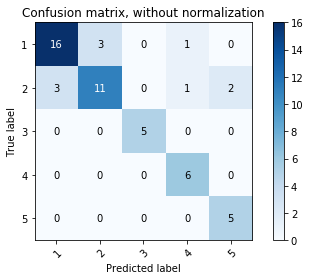

In [44]:
plot_confusion_matrix(y_test, best_predict, class_names)

### Support vector machine classifier

In [45]:
best_score = np.Infinity
best_predict = None
best_feature_importance = []

scores_svc = []

for i in range(iteration_n):

    clf = svm.SVC(gamma='scale')

    clf.fit(X=X_train, y=y_train)
    y_predict = clf.predict(X_test)
    current_score = accuracy_score(y_test, y_predict)
    
    scores_svc.append(current_score)
    
    if(current_score < best_score):
        best_score = current_score
        best_predict = y_predict

best_score

1.0

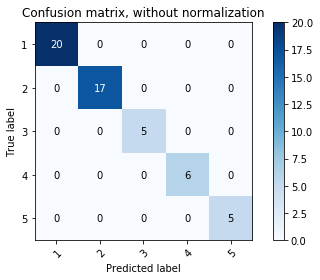

In [46]:
plot_confusion_matrix(y_test, best_predict, class_names)

### k-nearest neighbours classifier

In [47]:
best_score = np.Infinity
best_predict = None

scores_knn = []

for i in range(iteration_n):

    clf = KNeighborsClassifier(n_neighbors=3)

    clf.fit(X=X_train, y=y_train)
    y_predict = clf.predict(X_test)
    current_score = accuracy_score(y_test, y_predict)
    
    scores_knn.append(current_score)
    
    if(current_score < best_score):
        best_score = current_score
        best_predict = y_predict

best_score

0.8490566037735849

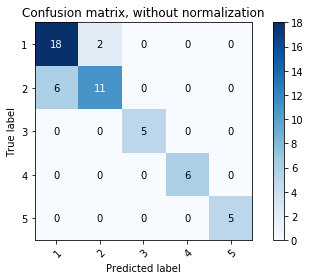

In [48]:
plot_confusion_matrix(y_test, best_predict, class_names)

In [49]:
print("La moyenne de tout les scores :")
print("+ Decision tree classifier : {:.3f}".format(np.mean(scores_dtc)))
print("+ Support vector machine classifier : {:.3f}".format(np.mean(scores_svc)))
print("+ k-nearest neighbours classifier : {:.3f}".format(np.mean(scores_knn)))

La moyenne de tout les scores :
+ Decision tree classifier : 0.870
+ Support vector machine classifier : 1.000
+ k-nearest neighbours classifier : 0.849


**Sans rien**

La moyenne de tout les scores :
+ Decision tree classifier : 0.764
+ Support vector machine classifier : 0.604
+ k-nearest neighbours classifier : 0.717

**Variance threshold (0.497)**

La moyenne de tout les scores :
+ Decision tree classifier : 0.790
+ Support vector machine classifier : 0.849
+ k-nearest neighbours classifier : 0.717

**Recursive features elimination (500)**

La moyenne de tout les scores :
+ Decision tree classifier : 0.892
+ Support vector machine classifier : 0.981
+ k-nearest neighbours classifier : 0.849

**Recursive features elimination (750)**

La moyenne de tout les scores :
+ Decision tree classifier : 0.884
+ Support vector machine classifier : 0.943
+ k-nearest neighbours classifier : 0.849

**Recursive features elimination (1000)**

La moyenne de tout les scores :
+ Decision tree classifier : 0.882
+ Support vector machine classifier : 0.981
+ k-nearest neighbours classifier : 0.849

**Recursive features elimination (2000)**

La moyenne de tout les scores :
+ Decision tree classifier : 0.858
+ Support vector machine classifier : 0.962
+ k-nearest neighbours classifier : 0.849

**Unvariant Selection (500)**

La moyenne de tout les scores :
+ Decision tree classifier : 0.793
+ Support vector machine classifier : 0.811
+ k-nearest neighbours classifier : 0.774

**Unvariant Selection (1000)**

La moyenne de tout les scores :
+ Decision tree classifier : 0.814
+ Support vector machine classifier : 0.849
+ k-nearest neighbours classifier : 0.906

**Unvariant Selection (2000)**

La moyenne de tout les scores :
+ Decision tree classifier : 0.764
+ Support vector machine classifier : 0.868
+ k-nearest neighbours classifier : 0.792